<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://media.licdn.com/dms/image/C4D12AQH-T7BYWr9clg/article-inline_image-shrink_1500_2232/0?e=2120536800&v=alpha&t=RrGrsyl8QPtDQjdKKw6VpEbJrTq1Dnigk89_t9vhbfw)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [0]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually.

In [0]:
from google.colab import files
files.upload()

Saving handout.tar.gz to handout.tar.gz


In [1]:
ls

sample_data/


### Data preprocessing

In [0]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 402 ms, sys: 372 ms, total: 774 ms
Wall time: 772 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [0]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [0]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [0]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for img in captions:
    for caption in img:
        for word in caption:
            word_counts[word] += 1

In [0]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [0]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [0]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm_notebook, tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython import display
from ipywidgets import IntProgress

In [0]:

class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048, shape_debug=False):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        self.n_tokens = n_tokens
        self.one_hotter = Variable(torch.arange(self.n_tokens), requires_grad=False)
        if not shape_debug:
            self.one_hotter = self.one_hotter.cuda()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Linear(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
#         print((self.one_hotter).type())
#         print((captions_ix[...,None]).long().type())
        
        # compute embeddings for captions_ix
        batch, word_i = captions_ix.shape
        one_hot = (self.one_hotter == (captions_ix[...,None]).long()).float()
        captions_emb = self.emb(one_hot)
        
#         print ("captions_emb:", captions_emb.shape)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, (hidden, cell) = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
#         print ("lstm_out:", lstm_out.shape)
                
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [0]:
network = CaptionNet(n_tokens, shape_debug=True)

In [0]:
dummy_img_vec = Variable(torch.randn(len(captions[0]), 2048), requires_grad=False)
dummy_capt_ix = Variable(torch.FloatTensor(as_matrix(captions[0])), requires_grad=False)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('logits:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

logits: torch.Size([5, 16, 10403])


In [0]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float Variable
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp).transpose(1, 2)
    
#     print ("captions_ix:", captions_ix.shape,
#            "\ncaptions_ix_next:", captions_ix_next.shape,
#            "\nlogits_for_next:", logits_for_next.shape)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next == pad_ix)
    # or by using ignore_index in some losses.
    
#     ignore_index = (captions_ix_next == pad_ix)
    
    
    
    loss = F.cross_entropy(logits_for_next, captions_ix_next.long(), ignore_index=pad_ix)
    
    return loss

In [0]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

print (dummy_loss)

assert dummy_loss.shape == torch.Size([]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

tensor(9.2451, grad_fn=<NllLoss2DBackward>)


In [0]:
dummy_loss.data.numpy()

array(9.245116, dtype=float32)

Create ~~adam~~ your favorite optimizer for the network.

# Training

* First implement the batch generator
* Than train the network as usual

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [0]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None, shape_debug=False):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    X = Variable(torch.FloatTensor(batch_images))
    y = Variable(torch.LongTensor(batch_captions_ix))
    
    if not shape_debug:
        X = X.cuda()
        y = y.cuda()
    
    return X, y
    

In [0]:
generate_batch(img_codes,captions,3, shape_debug=True)

(tensor([[0.1196, 0.0413, 0.1213,  ..., 0.0036, 0.0449, 0.6694],
         [0.6003, 0.1124, 0.1012,  ..., 0.3577, 0.7147, 0.0126],
         [0.7450, 0.2200, 0.5857,  ..., 0.0000, 0.7377, 0.8637]]),
 tensor([[   1,   24, 2163,    9,   58, 1378,   15,  671,   35,  367,   12,    2,
             3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
             3,    3],
         [   1,  112, 2757,   14,  195, 1371,  123,   24, 3865,  123,   71, 1006,
           123,  373,  357,  123, 3029,  123, 1379, 1374,  123,   15,  698,  357,
            12,    2],
         [   1,  112,    4,   17,   42,   94,    6,   24,  599,   12,    2,    3,
             3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
             3,    3]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [0]:
batch_size = 3  # adjust me
n_epochs = 2  # adjust me
n_batches_per_epoch = 4  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch
shape_debug = True

In [0]:
batch_size = 200  # adjust me
n_epochs = 40  # adjust me
print ("Total dataset is {} batches".format( img_codes.shape[0] / batch_size))
n_batches_per_epoch = 400 # adjust me
n_validation_batches = 100  # how many batches are used for validation after each epoch
shape_debug = False

Total dataset is 591.435 batches


In [0]:
network = CaptionNet(n_tokens, shape_debug=shape_debug)
opt = torch.optim.Adam(network.parameters())
if not shape_debug:
    network.cuda()
train_losses = []
val_losses = []
best_model = network
best_loss = np.inf

In [0]:
for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm_notebook(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        opt.zero_grad()

        loss_t.backward()

        opt.step()
        
#         train_loss += loss_t.data.numpy()[0]
        train_loss += loss_t.data.cpu().numpy().item()
        
    train_loss /= n_batches_per_epoch
    train_losses.append(train_loss)
    
    val_loss=0
    network.train(False)
    for _2 in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.data.cpu().numpy().item()
    val_loss /= n_validation_batches
    val_losses.append(val_loss)
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = deepcopy(network)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(train_losses, 'b', label="train")
    plt.plot(val_losses, 'g', label="val")
    plt.legend()
    plt.show()

print("Finished!")

torch.cuda.LongTensor
torch.cuda.LongTensor
torch.cuda.LongTensor
torch.cuda.LongTensor



RuntimeError: CUDA out of memory. Tried to allocate 238.12 MiB (GPU 0; 7.92 GiB total capacity; 608.05 MiB already allocated; 224.81 MiB free; 143.95 MiB cached)

In [0]:
from time import sleep
for i in range(10):
    display.clear_output(wait=True)
    for _ in tqdm(range(1000)):
        sleep(0.01)
    print("Ready.")

 78%|███████▊  | 780/1000 [00:07<00:02, 98.52it/s]


KeyboardInterrupt: 

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [0]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False).cuda()

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [0]:
def generate_caption(image, caption_prefix = ("START",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = Variable(torch.FloatTensor(image.transpose([2, 0, 1]))).cuda()
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.LongTensor(prefix_ix).cuda()
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).data.cpu().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [0]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2018-05-06 08:57:00--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.112.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.112.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 105,40K  --.-KB/s    in 0,1s    

2018-05-06 08:57:01 (812 KB/s) - ‘data/img.jpg’ saved [107928/107928]



/home/dima/apps/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


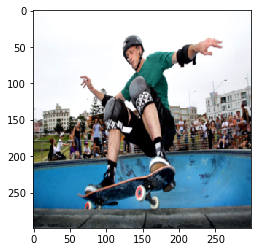

In [0]:
plt.imshow(img)

In [0]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a skateboarder doing a trick on a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a skateboarder is doing a trick on a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard on a ramp .
a skateboarder is doing a trick on a ramp .


--2018-05-06 08:55:14--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 64.207.177.234
Connecting to ccanimalclinic.com (ccanimalclinic.com)|64.207.177.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104,37K   165KB/s    in 0,6s    

2018-05-06 08:55:15 (165 KB/s) - ‘data/img.jpg’ saved [106870/106870]



/home/dima/apps/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


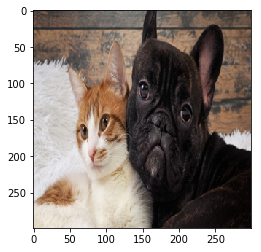

a black and white cat wearing a red shirt and tie .
a cat is looking at a cat on a couch .
a cat is looking at a black and white cat .
a cat is sitting on a couch with a cat .
a cat is laying on a couch in a room .
a cat is looking at a black and white cat
a cat with a collar sitting on a couch .
a black and white cat sitting on a chair .
a cat is looking at a cat on a bed .
a cat is laying on a black suitcase


In [0]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

In [0]:
#apply your network on image sample you found
#
#
def describe_img(url, img_ix=0, t=1, captions=10):
    filename = "data/img{}.jpg".format(img_ix)
    !wget -q "$url" -O "$filename"
    img = plt.imread(filename)
    img = imresize(img, (299, 299)).astype('float32') / 255.

    plt.imshow(img)
    plt.show()

    for i in range(captions):
        print(' '.join(generate_caption(img, t=t)[1:-1]))

/home/dima/apps/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


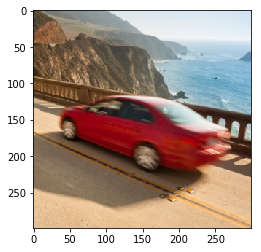

a small white car parked on a city street .
a small white car sitting on the side of a road .
a small white car parked on the side of a road .
a car parked on a sidewalk next to a car .
a large white car parked on a sidewalk in front of a building .
a small boat is parked on the side of the road .
a small car is parked on the side of the road .
a small white car parked next to a small boat .
a small car parked in a parking lot near a building .
a small white car parked on a city street


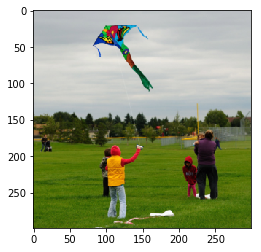

a person flying a kite in a field .
a man is flying a kite on a beach .
a man is flying a kite in a field .
a man is flying a kite in the air
a group of people flying kites on a beach .
a man flying a kite in the sky with a kite .
a man is flying a kite in a field .
a man flying a kite in a blue sky .
a man flying a kite on a beach .
a man flying a kite in a blue sky .


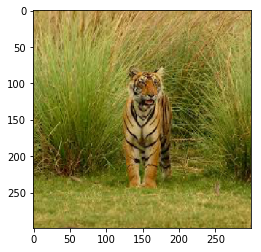

a couple of animals are sitting on a wooden bench .
a black and white photo of a man on a horse .
a black and white dog laying on a blue and white train .
a white and black dog laying on a green grass covered field .
a train is on a track with a mountain in the background .
a black and white photo of a man in a blue shirt and a black and white cat .
a couple of cows are standing in a field .
a white and black train on a track .
a large white and red train on a track .
a small train is on a track near a mountain .


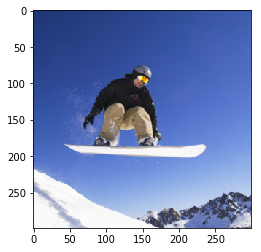

a man in a wetsuit riding a wave on a surfboard .
a man in a wetsuit riding a surfboard on a wave .
a man riding a surfboard on a wave in the ocean .
a man on a surfboard riding a wave .
a man on a surfboard riding a wave .
a man on a surfboard is in the water .
a man on a surfboard rides a wave .
a man riding a surfboard on a wave in the ocean .
a man riding a surfboard on a wave in the ocean .
a man riding a wave on a surfboard .


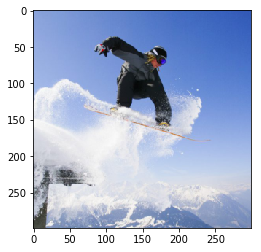

a man riding a snowboard down a snow covered slope .
a person on a snowboard jumping in the air .
a man riding a snowboard down a snow covered slope .
a man riding a snowboard down a snow covered slope .
a man riding a snowboard down a snow covered slope .
a man on a snowboard jumping in the air .
a man riding a snowboard down a snow covered slope .
a man riding a snowboard down a snow covered slope .
a man riding a snowboard down a snow covered slope .
a man riding a snowboard down a snow covered slope .


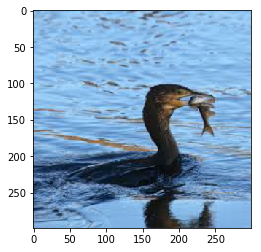

a duck is swimming in the water with a bird on the back .
a duck floating in the water with a bird on it .
a small boat is floating in the water .
a duck floating on a body of water .
a duck swimming in the water near a body of water .
a duck swimming in the water with a small wave .
a duck is floating in a body of water
a duck swimming in the water with a bird on the back .
a duck swimming in the water with a bird on the shore .
a duck swimming in the water with a bird on the side .


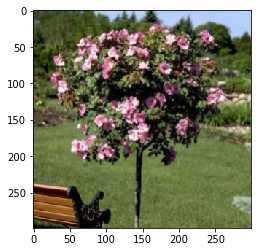

a bird sitting on a lush green field next to a field .
a bird is flying over a park bench .
a red fire hydrant in a field with a tree in the background .
a bird sitting on a lush green field with a tree in the grass .
a bird is flying over a lush green field .
a giraffe standing in a grassy area next to a tree .
a park bench with a blue and white bird on it
a large white bird sitting on a lush green field .
a park bench with a bird on the grass
a fire hydrant in a field with a tree in the background


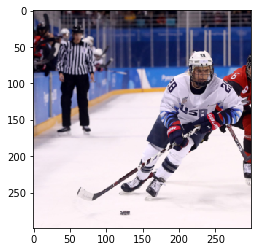

a man riding a skateboard down a street .
a man riding a skateboard down a street .
a man riding a skateboard down a street .
a man riding a skateboard down a street .
a man riding a skateboard down a street .
a man riding a skateboard down a street .
a man riding a skateboard down a street .
a man riding a skateboard down a street .
a man riding a skateboard down a ramp .
a man riding a skateboard down a street .


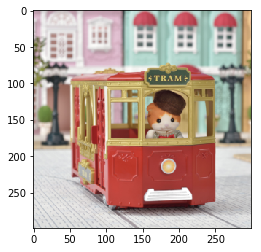

a large group of people sitting at a table with a clock .
a large #UNK# of a large clock on a building .
a large red and white teddy bear sitting on a table .
a large red and white train sitting on top of a train .
a large group of people standing around a table .
a large display of a large clock on a building .
a large group of people at a table with a cake .
a large collection of stuffed animals on a table .
a large white and blue teddy bear on a table
a large group of people are sitting around a table .


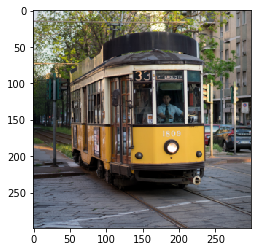

a red and white bus is driving down the street
a train on a train track with people walking around
a trolley is parked on the side of the road .
a red and white bus driving down a street .
a large long bus on a city street .
a trolley car is driving down the street .
a yellow and red bus on a city street .
a yellow and blue train traveling down a city street .
a red and white bus is parked in a lot .
a red and white train driving down a city street .


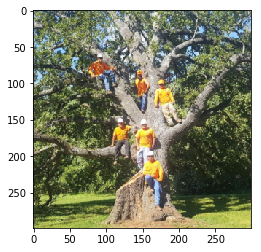

a little boy is riding a horse in the wild .
a little girl is standing on a tree branch .
a little girl wearing a red shirt is riding a horse .
a boy is standing in front of a tree with a frisbee .
a little boy is riding a horse in the field .
a little girl in a red shirt is holding a yellow frisbee
a man is standing next to a fire hydrant .
a little boy in a red shirt is on a horse
a man and a woman are on a red and white horse .
a boy is looking at a yellow frisbee .


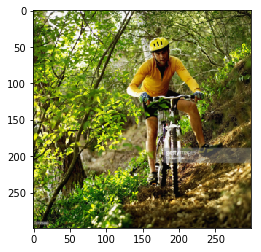

a man riding a bike down a street .
a man riding a bike down a dirt road .
a man riding a bike down a street .
a man riding a bike on a dirt road .
a man riding a bike down a street .
a man riding a skateboard down a street .
a man riding a bicycle down a street .
a man riding a bike past a large body of water .
a man riding a bike down a street .
a man riding a bike down a dirt road .


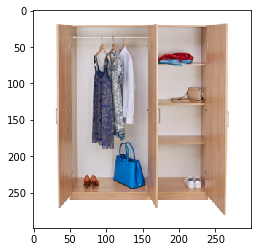

a cat standing next to a door with a door open .
a small cat is sitting in a chair in a room .
a cat is sitting in a chair on a shelf .
a cat is standing in a room with a door open .
a small cat standing in a room with a window .
a cat is sitting in a chair in a room .
a cat sitting on a floor in a room .
a cat sitting in a chair in a room .
a small child is standing in a room with a large window .
a small child sitting in the middle of a room .


In [0]:
imgs = ["http://d1arsn5g9mfrlq.cloudfront.net/sites/default/files/jdpower_vds_16_612px.jpg",
        "http://www.callingwoodlymburn.com/wp-content/uploads/2014/04/aDSC_0332-copy1.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTVQMCWyO9TrYz4GKi1sfn8YBOZm6QfUU440b4UJW7tHuorVuxb",
        "http://img-aws.ehowcdn.com/560x560p/photos.demandstudios.com/getty/article/103/146/80609063.jpg",
        "http://img-aws.ehowcdn.com/560x560p/photos.demandstudios.com/getty/article/189/75/80609241.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQlI9kJq0OryLeYDp21pIvtmp7-5RABdwr6tw5xXr-WrBOR2gmu",
        "https://www.naturehills.com/media/catalog/product/cache/d73a5018306142840707bd616a4ef293/p/o/polar-joy-rose-tree-landscape-425x425.jpg",
        "https://cdn.vox-cdn.com/thumbor/0UVxHDfVMZZsYnWvtgbLA0f1E88=/1400x1400/filters:format(jpeg)/cdn.vox-cdn.com/uploads/chorus_asset/file/10262643/918412990.jpg.jpg",
        "https://johnlewis.scene7.com/is/image/JohnLewis/237329776alt2?$rsp-pdp-main-1440$",
        "https://c1.staticflickr.com/3/2931/33296922504_7996127aa0_b.jpg",
        "https://static1.squarespace.com/static/59d3dd4e64b05f18eb046e42/t/59fa036ec8302541485f229f/1518848938931/stump+grinding+Woodlands+Conroe+Spring+Magnolia+montgomery"
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTTwNURmgMVOLN0qsltQJjKiSJHmoE25cMyGoheYh6dYfR1bA1S",
        "https://media.gettyimages.com/photos/young-man-cycling-in-a-forest-picture-id57305695",
        "",
        "",
        "",
        "",
        "",
        "https://www.ikea.com/gb/en/images/products/domb%C3%A5s-wardrobe-oak-effect__0461324_pe607496_s4.jpg",
       ]
for i, url in enumerate(imgs):
    if url:
        describe_img(url, i, t=3.5)

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563